In [ ]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
# !pip install scipy==1.1.0

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Imports

import os
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import random
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from metrics import eval_metrics
from utils import save_checkpoint, load_checkpoint, weight_decay, visualize_data, init_weights 
from model import R2UNet
from tqdm import tqdm
from torch.utils import data
from loader import cityscapesLoader
from train import train
from augmentations import Compose, RandomHorizontallyFlip, RandomRotate, RandomVerticallyFlip
from evaluate import evaluation
from result_visualization import result_vis

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #"cuda"

### 3.1 Defining the model architecture

In [5]:
model = R2UNet()
init_weights(model, init_type='kaiming', gain=0.02)

model initialization with kaiming


### 3.2 Hyperparameters

In [6]:
bs = 3
epochs = 20
lr = 0.0001

### 3.3 Dataset and Dataloader

In [7]:
local_path = '/arja_raid/datasets/Cityscapes/'

augs = Compose([RandomRotate(10), RandomHorizontallyFlip(0.5), RandomVerticallyFlip(0.5)])

traindataset = cityscapesLoader(root=local_path, is_transform=True, split='train', augmentations=augs)
validdataset = cityscapesLoader(root=local_path, is_transform=True, split='val')

# dataloader variable
trainloader = data.DataLoader(traindataset, batch_size=bs, shuffle=True)
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

print(f'Number of training images: {len(traindataset)}')
print(f'Number of validation images: {len(validdataset)}')

Found 2975 train images
Found 500 val images
Number of training images: 2975
Number of validation images: 500


**Visualizing the Images and Ground Truths**

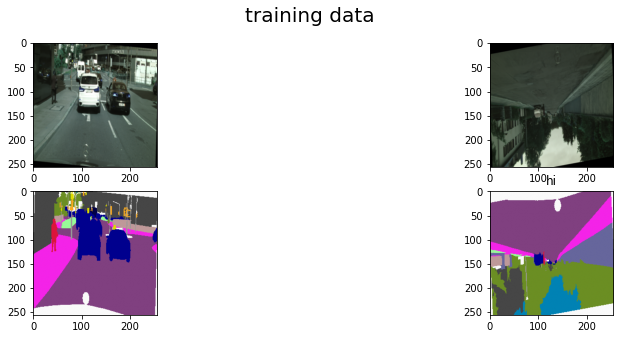

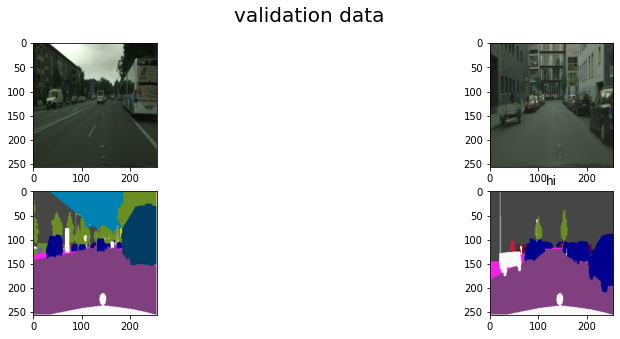

In [9]:
# Verifying training and validation data
num_vis_img = 2 # should be less than the batch size
visualize_data(num_vis_img, trainloader, traindataset, 'training data')
visualize_data(num_vis_img, validloader, validdataset, 'validation data')

**Run Cell 3.4 and 3.5, Only If You Intend to Train a Model**

### 3.4 Loss fuction and Optimizer

In [10]:
# loss function
loss_f = nn.CrossEntropyLoss(size_average = True, ignore_index=250)

# optimizer variable
params = weight_decay(model, l2_value=0.0001)
opt = torch.optim.Adam(params, lr=lr)

### 3.5 Training the model

In [11]:
model.to(device)

R2UNet(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (RR_block1): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.5, inplace=False)
        )
      )
      (1): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RR_block2): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
    

In [ ]:
criterion = loss_f
checkpoint_name = "/arja_raid/trained_models/Task_2_new/m2_r2unet_ep_" 
# add: str(epoch) + ".pth.tar" at the end of this string to evaluate the desired model 
history = train(traindataset, validdataset, trainloader, validloader,\
                model, criterion, opt, epochs, checkpoint_name, device)

Validation Epoch 1:  84%|████████▍ | 140/166 [01:55<00:22,  1.16it/s, loss=5.01]

In [ ]:
fig = plt.figure()
plt.plot(history[0])
plt.plot(history[2])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### 3.6 Evaluating the trained model on validation/training dataset

In [ ]:
local_path = '/arja_raid/datasets/Cityscapes/'

validdataset = cityscapesLoader(root=local_path, is_transform=True, split='val')
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

model = R2UNet()
model.to(device)
checkpoint_path = "/arja_raid/trained_models/Task2/m2_r2unet_ep_"

evaluation(checkpoint_path, validdataset, validloader, bs, model, device)


In [ ]:
# Metrics plotting for all epochs

iou_list = []
dice_list = []
f1_list = []
acc_list = []
auc_list = []

for epoch in range(0,29):
    model = R2UNet()
    model.to(device)
    checkpoint_path = '/arja_raid/trained_models/Task2/m2_r2unet_ep_' + str(epoch) + '.pth.tar'
    iou_sc, dice_sc, f1_sc, acc_sc, auc_sc = evaluation(checkpoint_path, validdataset, validloader, bs, model, device)
    iou_list.append(iou_sc)
    dice_list.append(dice_sc)
    f1_list.append(f1_sc)
    acc_list.append(acc_sc)
    auc_list.append(auc_sc)
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,4))
ax1.plot(iou_list)
ax1.set_title("IoU")
ax2.plot(dice_list)
ax2.set_title("Dice")
ax3.plot(f1_list)
ax3.set_title("F1")
ax4.plot(acc_list)
ax4.set_title("Accuracy")
ax5.plot(auc_list)
ax5.set_title("AUC")
plt.show()
plt.savefig('m4_dplabv3_aug_30epoch.png')

### 3.7 Visualize results

In [ ]:
local_path = '/arja_raid/datasets/Cityscapes/'

validdataset = cityscapesLoader(root=local_path, is_transform=True, split='val')
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

model = R2UNet()
model.to(device)
checkpoint_path = "/arja_raid/trained_models/Task2/m2_r2unet_ep_27.pth.tar"

result_vis(checkpoint_path, validdataset, validloader, bs, model, device)
